# <center>Classification binaire des images de type photo</center>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import PIL
import datetime

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import seaborn as sns
from keras.models import load_model

2024-01-11 14:50:14.356189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 14:50:14.356294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 14:50:14.398895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 14:50:14.530349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:50:16.215209: W tensorflow/compiler/tf2

### Congfiguration de l'environnement pour l'entraînement

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
# IMAGE_SIZE = (90, 90)
IMAGE_SIZE = (40, 40)
EPOCHS = 50
NUM_CLASSES_BINAIRE = 2
NUM_CLASSES_MULTICLASSE = 5

### Import des données

In [3]:
def get_dataset_binaire():
    return tf.keras.utils.image_dataset_from_directory(
        "/home/nathan/AI/Projet/Dataset binaire/",
        labels="inferred",
        label_mode='binary',
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="both",
        interpolation='area' #area pour rétrecir / bicubic pour élargir
    )

def get_dataset_multiclasse():
    return tf.keras.utils.image_dataset_from_directory(
        "/home/nathan/AI/Projet/Dataset multiclasse/",
        labels="inferred",
        label_mode='int',
        color_mode='grayscale',
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        seed=42,
        validation_split=0.2,
        subset="both",
        interpolation='area' #area pour rétrecir / bicubic pour élargir
    )

In [4]:
train_binaire, validation_binaire = get_dataset_binaire()
classes_binaire = train_binaire.class_names
train_multiclasse, validation_multiclasse = get_dataset_multiclasse()
classes_multiclasse = train_multiclasse.class_names

Found 41407 files belonging to 2 classes.
Using 33126 files for training.
Using 8281 files for validation.


2024-01-11 14:50:22.634935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:50:22.905620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:50:22.905706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:50:22.907959: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-11 14:50:22.908069: I external/local_xla/xla/stream_executor

Found 41407 files belonging to 5 classes.
Using 33126 files for training.
Using 8281 files for validation.


In [5]:
print(f"Classes binaire : {classes_binaire}")
print(f"Classes multiclasse : {classes_multiclasse}")

Classes binaire : ['Autres', 'Photo']
Classes multiclasse : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


### Exploration et visualisation des données

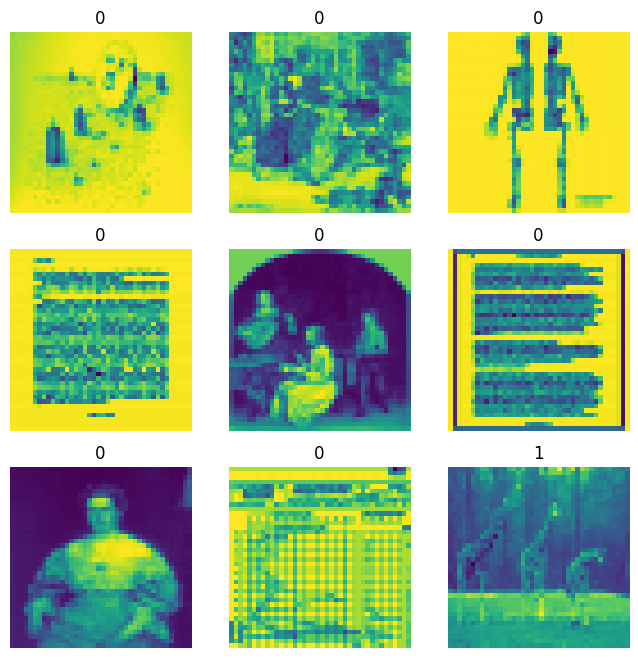

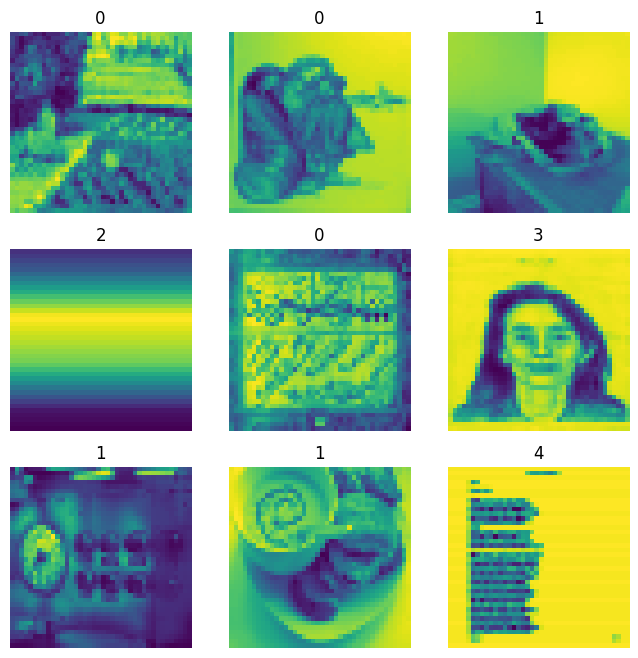

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_binaire.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype(int)[0])
        plt.axis("off")

plt.figure(figsize=(8, 8))
for images, labels in train_multiclasse.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype(int))
        plt.axis("off")

In [7]:
print("Shape du dataset binaire :")
for batch in train_binaire.take(1):
    print(batch[0].shape)

print("\nShape du dataset multiclasse :")
for batch in train_multiclasse.take(1):
    print(batch[0].shape)

Shape du dataset binaire :
(32, 40, 40, 1)

Shape du dataset multiclasse :
(32, 40, 40, 1)


## I. Models Machine Learning

### Convertir les tensors en numpy arrays

In [ ]:
images_train, labels_train, images_validation, labels_validation = [], [], [], []

for image_batch, label_batch in train_binaire:
    images_train.extend(image_batch.numpy())
    labels_train.extend(label_batch.numpy())

In [ ]:
for image_batch, label_batch in validation_binaire:
    images_validation.extend(image_batch.numpy())
    labels_validation.extend(label_batch.numpy())

In [ ]:
images_train = np.array(images_train)
images_validation = np.array(images_validation)

In [ ]:
labels_train = np.array(labels_train)
labels_validation = np.array(labels_validation)

In [ ]:
X_train = images_train.reshape(images_train.shape[0], -1)
y_train = labels_train.ravel()

X_validation = images_validation.reshape(images_validation.shape[0], -1)
y_validation = labels_validation.ravel()

In [ ]:
print("X_train shape : {}".format(str(X_train.shape)))
print("y_train shape : {}".format(str(y_train.shape)))
print("X_validation shape : {}".format(str(X_validation.shape)))
print("y_validation shape : {}".format(str(y_validation.shape)))

### Model Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300, max_depth=9, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
predictions_train, predictions_validation = [], []
for tree in rf.estimators_:
    predictions_train.append(tree.predict_proba(X_train)[None, :])
    predictions_validation.append(tree.predict_proba(X_validation)[None, :])

In [ ]:
predictions_train = np.vstack(predictions_train)
predictions_validation = np.vstack(predictions_validation)

In [ ]:
cum_mean_train = np.cumsum(predictions_train, axis=0)/np.arange(1, predictions_train.shape[0] + 1)[:, None, None]
cum_mean_validation = np.cumsum(predictions_validation, axis=0)/np.arange(1, predictions_validation.shape[0] + 1)[:, None, None]

In [ ]:
scores_train, scores_validation = [], []
for pred in cum_mean_train:
    scores_train.append(accuracy_score(y_train, np.argmax(pred, axis=1)))
for pred in cum_mean_validation:
    scores_validation.append(accuracy_score(y_validation, np.argmax(pred, axis=1)))

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores_train, linewidth=3, color="b")
plt.plot(scores_validation, linewidth=3, color="r")
plt.xlabel('num_trees')
plt.ylabel('accuracy')

In [ ]:
best_n_estimators = scores_validation.index(max(scores_validation))
print(f"Meilleur n_estimator : {best_n_estimators}")

In [ ]:
rf = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=9, random_state=42)
rf.fit(X_train, y_train)

print(f"Score on train: {str(rf.score(X_train, y_train))}")
print(f"Score on validation: {str(rf.score(X_validation, y_validation))}")

y_pred_validation = rf.predict(X_validation)

cm = confusion_matrix(y_validation, y_pred_validation)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_binaire)
disp.plot()
plt.show()

## II. Models Deep Learning

### 1. CNN

#### CNN 3 couches

In [8]:
model_binaire = Sequential([
    layers.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES_BINAIRE)
])

model_multiclasse = Sequential([
    layers.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES_MULTICLASSE)
])

In [9]:
model_binaire.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_binaire.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_binaire.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 40, 40, 1)           0         
                                                                 
 conv2d (Conv2D)             (32, 40, 40, 16)          160       
                                                                 
 max_pooling2d (MaxPooling2  (32, 20, 20, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 20, 20, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 10, 10, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 10, 10, 64)          1

In [10]:
model_multiclasse.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_multiclasse.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_multiclasse.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 40, 40, 1)           0         
                                                                 
 conv2d_3 (Conv2D)           (32, 40, 40, 16)          160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 20, 20, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (32, 20, 20, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 10, 10, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 10, 10, 64)         

In [14]:
def show_metrics(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(history.history['loss']))

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [12]:
callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=(EPOCHS/10))

Epoch 1/50


2024-01-11 12:19:00.210435: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-11 12:19:02.840203: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 12:19:03.555520: I external/local_xla/xla/service/service.cc:168] XLA service 0x55b231fefec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 12:19:03.555586: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-01-11 12:19:03.578270: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704971943.774033   38951 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  65/1036 [>.............................] - ETA: 1:01 - loss: 0.4772 - accuracy: 0.7437

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 112s 97ms/step - loss: 0.3528 - accuracy: 0.8114 - val_loss: 0.3105 - val_accuracy: 0.8408
Epoch 2/50


/home/nathan/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  66/1036 [>.............................] - ETA: 1:06 - loss: 0.3099 - accuracy: 0.8371

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 97s 93ms/step - loss: 0.2940 - accuracy: 0.8554 - val_loss: 0.2621 - val_accuracy: 0.8768
Epoch 3/50
  65/1036 [>.............................] - ETA: 1:03 - loss: 0.2635 - accuracy: 0.8736

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 99s 95ms/step - loss: 0.2599 - accuracy: 0.8815 - val_loss: 0.2445 - val_accuracy: 0.8893
Epoch 4/50
  65/1036 [>.............................] - ETA: 1:01 - loss: 0.2402 - accuracy: 0.9000

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 98s 94ms/step - loss: 0.2366 - accuracy: 0.8946 - val_loss: 0.2397 - val_accuracy: 0.8879
Epoch 5/50
  65/1036 [>.............................] - ETA: 1:06 - loss: 0.2187 - accuracy: 0.9048

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 98s 94ms/step - loss: 0.2207 - accuracy: 0.9019 - val_loss: 0.2435 - val_accuracy: 0.8882
Epoch 6/50
  65/1036 [>.............................] - ETA: 1:06 - loss: 0.2125 - accuracy: 0.9062

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 103s 99ms/step - loss: 0.2027 - accuracy: 0.9119 - val_loss: 0.2320 - val_accuracy: 0.8968
Epoch 7/50
  64/1036 [>.............................] - ETA: 1:08 - loss: 0.1929 - accuracy: 0.9102

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 100s 95ms/step - loss: 0.1865 - accuracy: 0.9189 - val_loss: 0.2424 - val_accuracy: 0.8925
Epoch 8/50
  66/1036 [>.............................] - ETA: 1:08 - loss: 0.1711 - accuracy: 0.9280

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 100s 96ms/step - loss: 0.1680 - accuracy: 0.9281 - val_loss: 0.2442 - val_accuracy: 0.8945
Epoch 9/50
  62/1036 [>.............................] - ETA: 3:59 - loss: 0.1625 - accuracy: 0.9345

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 118s 113ms/step - loss: 0.1496 - accuracy: 0.9370 - val_loss: 0.2776 - val_accuracy: 0.8867
Epoch 10/50
  65/1036 [>.............................] - ETA: 1:05 - loss: 0.1479 - accuracy: 0.9413

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 100s 96ms/step - loss: 0.1336 - accuracy: 0.9454 - val_loss: 0.2634 - val_accuracy: 0.8949
Epoch 11/50
  65/1036 [>.............................] - ETA: 1:06 - loss: 0.1254 - accuracy: 0.9466

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 102s 98ms/step - loss: 0.1167 - accuracy: 0.9516 - val_loss: 0.2837 - val_accuracy: 0.8934


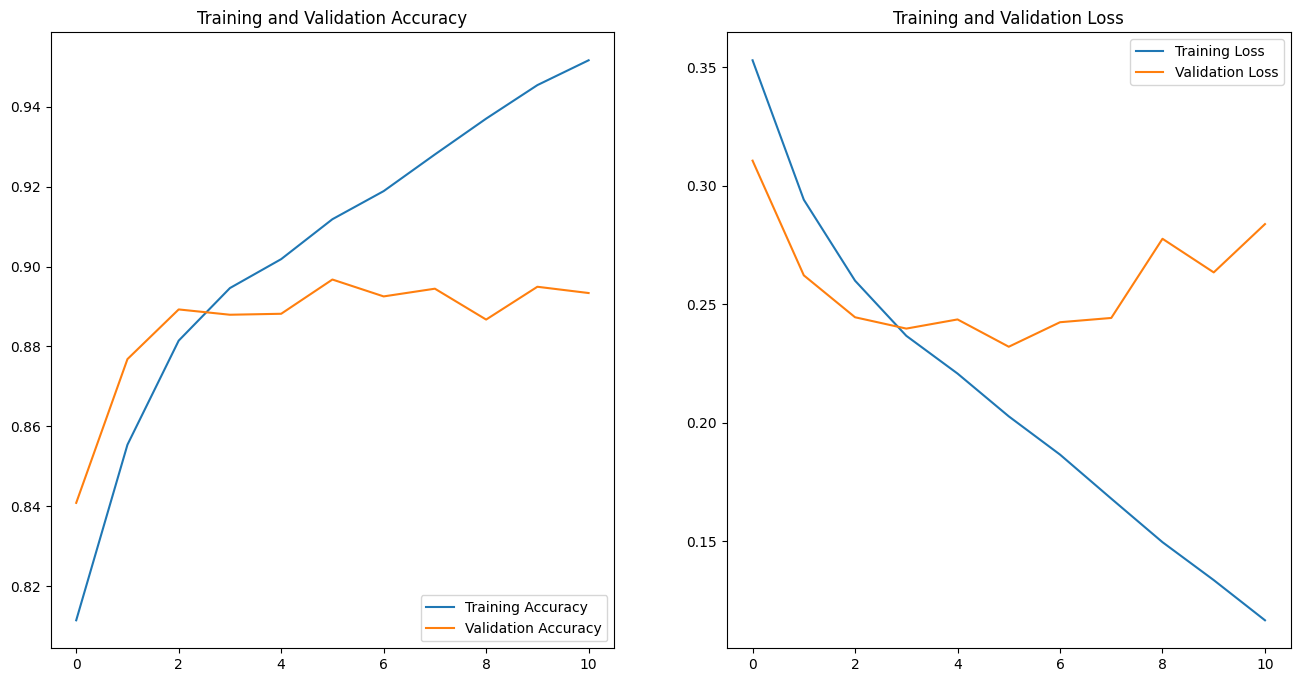

In [13]:
history = model_binaire.fit(
  train_binaire,
  validation_data=validation_binaire,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_binaire.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

Epoch 1/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.6906 - accuracy: 0.6984

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 104s 95ms/step - loss: 0.6901 - accuracy: 0.6986 - val_loss: 0.6179 - val_accuracy: 0.7204
Epoch 2/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4863 - accuracy: 0.7953

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 97s 92ms/step - loss: 0.4861 - accuracy: 0.7954 - val_loss: 0.4832 - val_accuracy: 0.7939
Epoch 3/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4162 - accuracy: 0.8280

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 91s 88ms/step - loss: 0.4161 - accuracy: 0.8280 - val_loss: 0.4036 - val_accuracy: 0.8353
Epoch 4/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.3767 - accuracy: 0.8451

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 90ms/step - loss: 0.3770 - accuracy: 0.8449 - val_loss: 0.3834 - val_accuracy: 0.8470
Epoch 5/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3490 - accuracy: 0.8586

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 95s 91ms/step - loss: 0.3491 - accuracy: 0.8586 - val_loss: 0.3552 - val_accuracy: 0.8588
Epoch 6/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.3265 - accuracy: 0.8684

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 89ms/step - loss: 0.3265 - accuracy: 0.8684 - val_loss: 0.3637 - val_accuracy: 0.8532
Epoch 7/50
1032/1036 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8812

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 89ms/step - loss: 0.2975 - accuracy: 0.8813 - val_loss: 0.3782 - val_accuracy: 0.8491
Epoch 8/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.2803 - accuracy: 0.8896

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 95s 92ms/step - loss: 0.2801 - accuracy: 0.8896 - val_loss: 0.3615 - val_accuracy: 0.8604
Epoch 9/50
1036/1036 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.8980

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 96s 92ms/step - loss: 0.2534 - accuracy: 0.8980 - val_loss: 0.3936 - val_accuracy: 0.8427
Epoch 10/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9061

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 91ms/step - loss: 0.2362 - accuracy: 0.9060 - val_loss: 0.3666 - val_accuracy: 0.8579


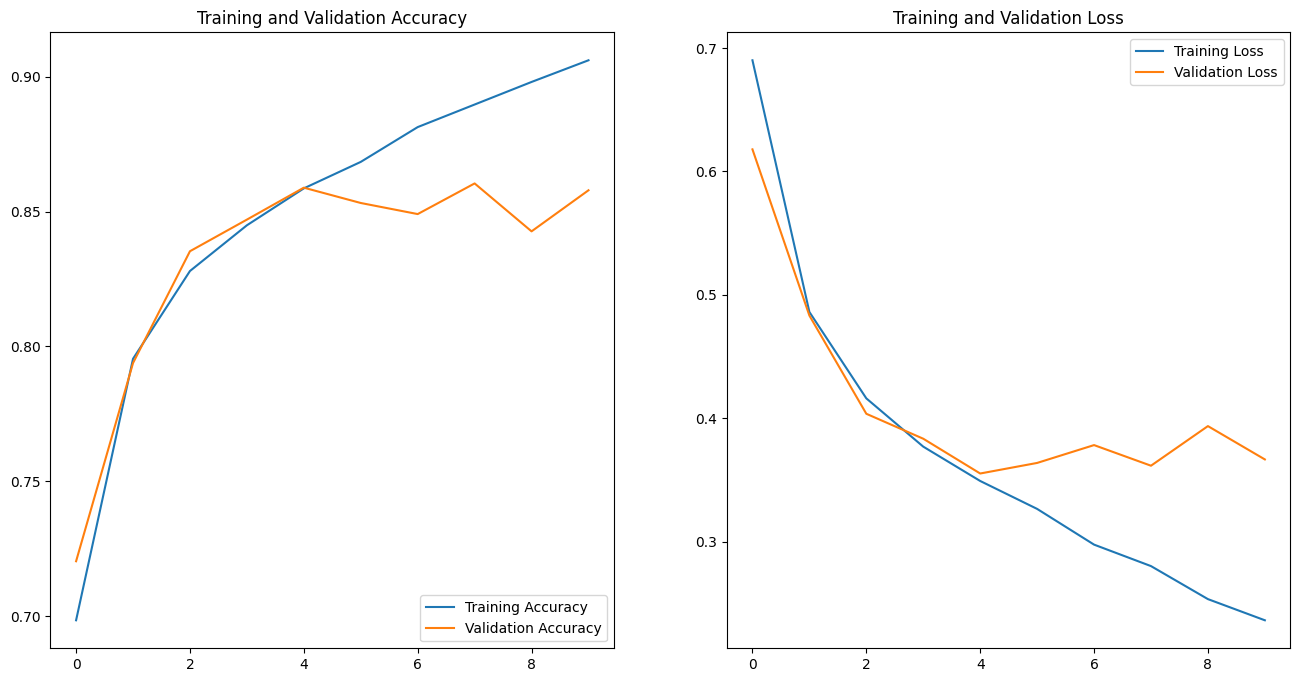

In [14]:
history = model_multiclasse.fit(
  train_multiclasse,
  validation_data=validation_multiclasse,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_multiclasse.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

#### Avec dropout

In [15]:
model_binaire = Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES_BINAIRE)
])

model_multiclasse = Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES_MULTICLASSE)
])

In [16]:
model_binaire.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_binaire.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_binaire.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (32, 40, 40, 1)           0         
                                                                 
 conv2d_6 (Conv2D)           (32, 40, 40, 16)          160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 20, 20, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 20, 20, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 10, 10, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 10, 10, 64)         

In [17]:
model_multiclasse.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_multiclasse.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_multiclasse.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (32, 40, 40, 1)           0         
                                                                 
 conv2d_9 (Conv2D)           (32, 40, 40, 16)          160       
                                                                 
 max_pooling2d_9 (MaxPoolin  (32, 20, 20, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (32, 20, 20, 32)          4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 10, 10, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (32, 10, 10, 64)         

Epoch 1/50


  64/1036 [>.............................] - ETA: 1:03 - loss: 0.4911 - accuracy: 0.7515

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 102s 94ms/step - loss: 0.3710 - accuracy: 0.7978 - val_loss: 0.3373 - val_accuracy: 0.8143
Epoch 2/50
  64/1036 [>.............................] - ETA: 1:03 - loss: 0.3310 - accuracy: 0.8315

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 90ms/step - loss: 0.3301 - accuracy: 0.8325 - val_loss: 0.2956 - val_accuracy: 0.8622
Epoch 3/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2995 - accuracy: 0.8582

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 87ms/step - loss: 0.3053 - accuracy: 0.8506 - val_loss: 0.2828 - val_accuracy: 0.8693
Epoch 4/50
  65/1036 [>.............................] - ETA: 1:01 - loss: 0.2892 - accuracy: 0.8707

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.2828 - accuracy: 0.8675 - val_loss: 0.2577 - val_accuracy: 0.8868
Epoch 5/50
  65/1036 [>.............................] - ETA: 1:06 - loss: 0.2805 - accuracy: 0.8702

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.2709 - accuracy: 0.8749 - val_loss: 0.2516 - val_accuracy: 0.8934
Epoch 6/50
  66/1036 [>.............................] - ETA: 1:01 - loss: 0.2542 - accuracy: 0.8830

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.2523 - accuracy: 0.8865 - val_loss: 0.2569 - val_accuracy: 0.8908
Epoch 7/50
  65/1036 [>.............................] - ETA: 1:02 - loss: 0.2355 - accuracy: 0.8942

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.2398 - accuracy: 0.8953 - val_loss: 0.2492 - val_accuracy: 0.8864
Epoch 8/50
  66/1036 [>.............................] - ETA: 1:01 - loss: 0.2320 - accuracy: 0.9034

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.2297 - accuracy: 0.9011 - val_loss: 0.2417 - val_accuracy: 0.8928
Epoch 9/50
  66/1036 [>.............................] - ETA: 1:01 - loss: 0.2184 - accuracy: 0.9067

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.2190 - accuracy: 0.9065 - val_loss: 0.2376 - val_accuracy: 0.8947
Epoch 10/50
  65/1036 [>.............................] - ETA: 1:01 - loss: 0.2079 - accuracy: 0.9192

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.2060 - accuracy: 0.9124 - val_loss: 0.2792 - val_accuracy: 0.8811
Epoch 11/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.1998 - accuracy: 0.9159

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.1969 - accuracy: 0.9167 - val_loss: 0.2375 - val_accuracy: 0.8982
Epoch 12/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9298

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.1884 - accuracy: 0.9219 - val_loss: 0.2427 - val_accuracy: 0.8960
Epoch 13/50
  65/1036 [>.............................] - ETA: 59s - loss: 0.1747 - accuracy: 0.9274 

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.1787 - accuracy: 0.9253 - val_loss: 0.2432 - val_accuracy: 0.8999
Epoch 14/50
  65/1036 [>.............................] - ETA: 59s - loss: 0.1722 - accuracy: 0.9337 

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.1680 - accuracy: 0.9313 - val_loss: 0.2393 - val_accuracy: 0.9001
Epoch 15/50
  65/1036 [>.............................] - ETA: 1:11 - loss: 0.1488 - accuracy: 0.9438

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 91s 88ms/step - loss: 0.1576 - accuracy: 0.9345 - val_loss: 0.2507 - val_accuracy: 0.8971
Epoch 16/50
  65/1036 [>.............................] - ETA: 1:01 - loss: 0.1458 - accuracy: 0.9413

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.1504 - accuracy: 0.9374 - val_loss: 0.2561 - val_accuracy: 0.8972


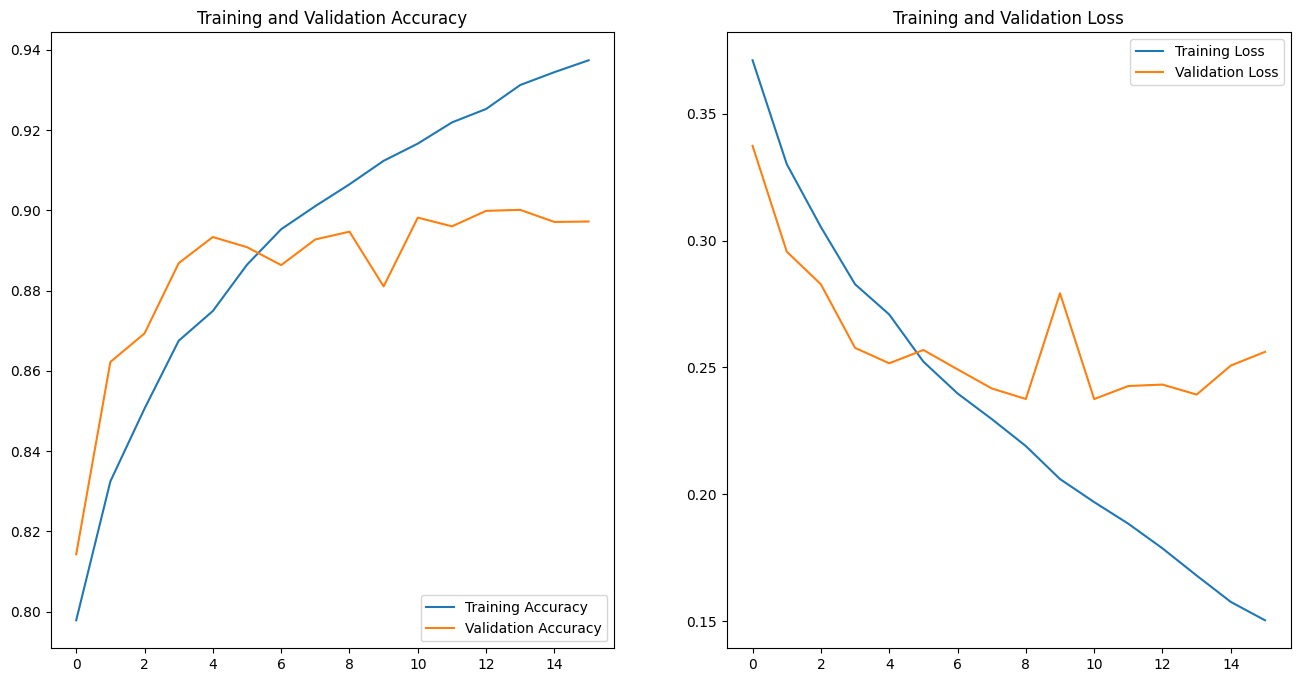

In [18]:
history = model_binaire.fit(
  train_binaire,
  validation_data=validation_binaire,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_binaire_dropout.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

Epoch 1/50


1036/1036 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.6150

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 97s 91ms/step - loss: 0.8317 - accuracy: 0.6150 - val_loss: 0.5993 - val_accuracy: 0.7146
Epoch 2/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.6336 - accuracy: 0.7003

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.6334 - accuracy: 0.7004 - val_loss: 0.5365 - val_accuracy: 0.7509
Epoch 3/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.5865 - accuracy: 0.7341

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.5863 - accuracy: 0.7341 - val_loss: 0.4818 - val_accuracy: 0.7934
Epoch 4/50
1036/1036 [==============================] - ETA: 0s - loss: 0.5351 - accuracy: 0.7635

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.5351 - accuracy: 0.7635 - val_loss: 0.4929 - val_accuracy: 0.7929
Epoch 5/50
1036/1036 [==============================] - ETA: 0s - loss: 0.5091 - accuracy: 0.7828

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 86ms/step - loss: 0.5091 - accuracy: 0.7828 - val_loss: 0.4293 - val_accuracy: 0.8243
Epoch 6/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.8010

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 85ms/step - loss: 0.4768 - accuracy: 0.8010 - val_loss: 0.4598 - val_accuracy: 0.7935
Epoch 7/50
1036/1036 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8108

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.4622 - accuracy: 0.8108 - val_loss: 0.3949 - val_accuracy: 0.8389
Epoch 8/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.4326 - accuracy: 0.8239

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 85ms/step - loss: 0.4326 - accuracy: 0.8239 - val_loss: 0.3808 - val_accuracy: 0.8418
Epoch 9/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4131 - accuracy: 0.8308

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.4131 - accuracy: 0.8308 - val_loss: 0.4125 - val_accuracy: 0.8197
Epoch 10/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8376

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 106s 102ms/step - loss: 0.3962 - accuracy: 0.8376 - val_loss: 0.3833 - val_accuracy: 0.8456
Epoch 11/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8448

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 87ms/step - loss: 0.3802 - accuracy: 0.8448 - val_loss: 0.3960 - val_accuracy: 0.8401
Epoch 12/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3657 - accuracy: 0.8517

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 86ms/step - loss: 0.3657 - accuracy: 0.8517 - val_loss: 0.3726 - val_accuracy: 0.8484
Epoch 13/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.3590 - accuracy: 0.8572

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 89ms/step - loss: 0.3589 - accuracy: 0.8573 - val_loss: 0.3590 - val_accuracy: 0.8584
Epoch 14/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8620

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 95s 91ms/step - loss: 0.3452 - accuracy: 0.8620 - val_loss: 0.3572 - val_accuracy: 0.8606
Epoch 15/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.8644

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 91s 87ms/step - loss: 0.3358 - accuracy: 0.8644 - val_loss: 0.3502 - val_accuracy: 0.8594
Epoch 16/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8727

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 87ms/step - loss: 0.3161 - accuracy: 0.8727 - val_loss: 0.3608 - val_accuracy: 0.8577
Epoch 17/50
1032/1036 [============================>.] - ETA: 0s - loss: 0.3126 - accuracy: 0.8760

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.3126 - accuracy: 0.8760 - val_loss: 0.3552 - val_accuracy: 0.8602
Epoch 18/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8791

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 83ms/step - loss: 0.3003 - accuracy: 0.8790 - val_loss: 0.3507 - val_accuracy: 0.8612
Epoch 19/50
1036/1036 [==============================] - ETA: 0s - loss: 0.2919 - accuracy: 0.8822

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 82ms/step - loss: 0.2919 - accuracy: 0.8822 - val_loss: 0.3504 - val_accuracy: 0.8645
Epoch 20/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.2798 - accuracy: 0.8851

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.2798 - accuracy: 0.8851 - val_loss: 0.3539 - val_accuracy: 0.8612


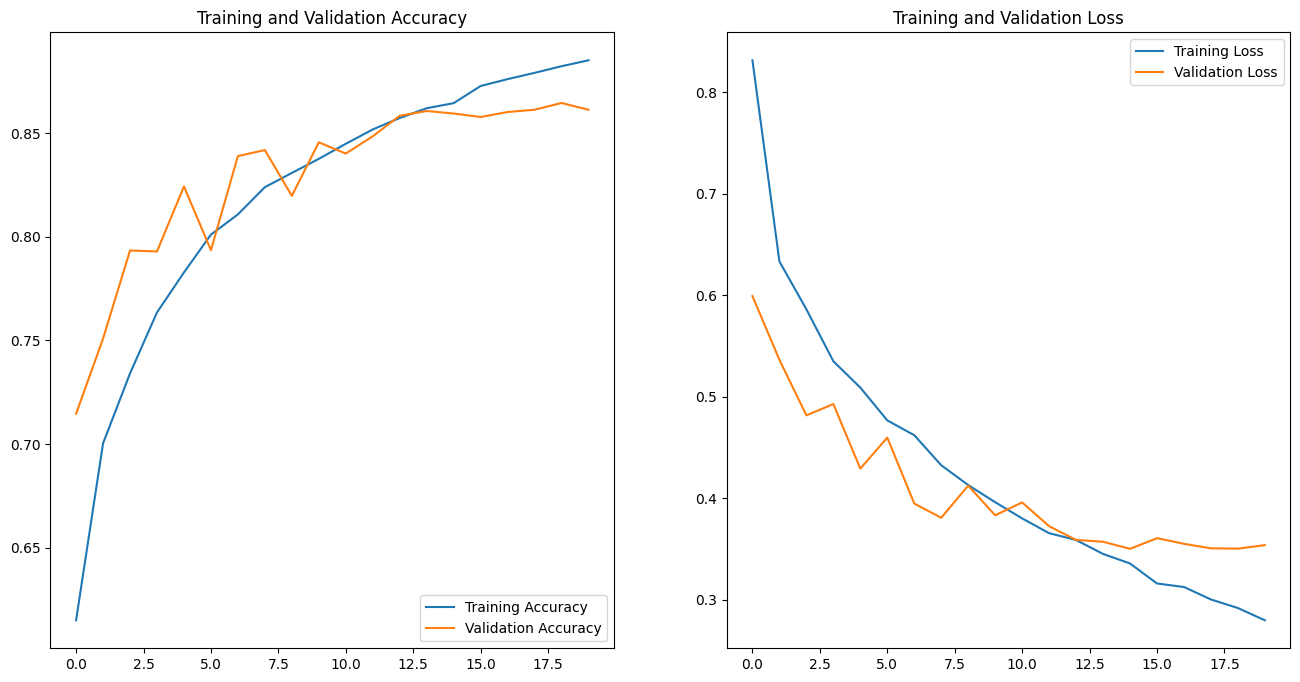

In [19]:
history = model_multiclasse.fit(
  train_multiclasse,
  validation_data=validation_multiclasse,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_multiclasse_dropout.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

#### Avec data augmentation

In [20]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model_binaire = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(NUM_CLASSES_BINAIRE)
])

model_multiclasse = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(NUM_CLASSES_MULTICLASSE)
])

In [21]:
model_binaire.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_binaire.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_binaire.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 40, 40, 1)         0         
                                                                 
 rescaling_4 (Rescaling)     (None, 40, 40, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 40, 40, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 20, 20, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 10, 10, 32)        0         
 ng2D)                                                

In [22]:
model_multiclasse.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_multiclasse.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_multiclasse.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 40, 40, 1)         0         
                                                                 
 rescaling_5 (Rescaling)     (None, 40, 40, 1)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 40, 40, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 20, 20, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 10, 10, 32)        0         
 ng2D)                                                

Epoch 1/50
  65/1036 [>.............................] - ETA: 1:05 - loss: 0.4888 - accuracy: 0.7452

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 91s 84ms/step - loss: 0.3627 - accuracy: 0.8035 - val_loss: 0.3380 - val_accuracy: 0.8129
Epoch 2/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.3231 - accuracy: 0.8332

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 84ms/step - loss: 0.3219 - accuracy: 0.8354 - val_loss: 0.3379 - val_accuracy: 0.8191
Epoch 3/50
  65/1036 [>.............................] - ETA: 1:02 - loss: 0.2956 - accuracy: 0.8553

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 84ms/step - loss: 0.3015 - accuracy: 0.8511 - val_loss: 0.2979 - val_accuracy: 0.8517
Epoch 4/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2794 - accuracy: 0.8606

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.2838 - accuracy: 0.8623 - val_loss: 0.3018 - val_accuracy: 0.8541
Epoch 5/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2842 - accuracy: 0.8611

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 84ms/step - loss: 0.2753 - accuracy: 0.8697 - val_loss: 0.3186 - val_accuracy: 0.8483
Epoch 6/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2595 - accuracy: 0.8784

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 91s 87ms/step - loss: 0.2703 - accuracy: 0.8732 - val_loss: 0.3209 - val_accuracy: 0.8396
Epoch 7/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2601 - accuracy: 0.8716

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.2628 - accuracy: 0.8779 - val_loss: 0.2760 - val_accuracy: 0.8655
Epoch 8/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2620 - accuracy: 0.8779

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.2565 - accuracy: 0.8795 - val_loss: 0.3256 - val_accuracy: 0.8425
Epoch 9/50
  65/1036 [>.............................] - ETA: 1:03 - loss: 0.2601 - accuracy: 0.8788

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.2540 - accuracy: 0.8819 - val_loss: 0.3390 - val_accuracy: 0.8430
Epoch 10/50
  65/1036 [>.............................] - ETA: 1:00 - loss: 0.2600 - accuracy: 0.8817

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 83ms/step - loss: 0.2537 - accuracy: 0.8836 - val_loss: 0.3104 - val_accuracy: 0.8550
Epoch 11/50
  65/1036 [>.............................] - ETA: 1:01 - loss: 0.2537 - accuracy: 0.8832

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.2452 - accuracy: 0.8876 - val_loss: 0.2933 - val_accuracy: 0.8598
Epoch 12/50
  66/1036 [>.............................] - ETA: 1:00 - loss: 0.2518 - accuracy: 0.8849

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.2449 - accuracy: 0.8880 - val_loss: 0.3197 - val_accuracy: 0.8523


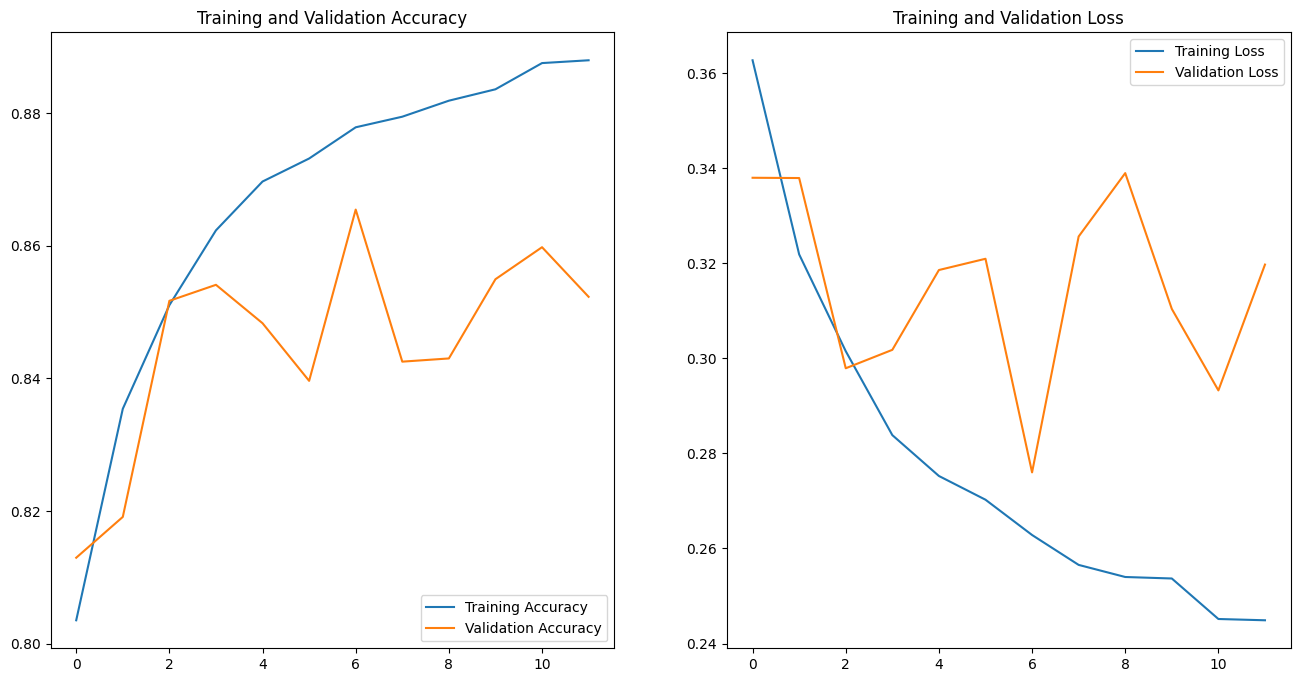

In [23]:
history = model_binaire.fit(
  train_binaire,
  validation_data=validation_binaire,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_binaire_dataaug.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

Epoch 1/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.8002 - accuracy: 0.6428

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 83ms/step - loss: 0.8002 - accuracy: 0.6427 - val_loss: 0.6359 - val_accuracy: 0.7289
Epoch 2/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.7485

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 82ms/step - loss: 0.5954 - accuracy: 0.7485 - val_loss: 0.6677 - val_accuracy: 0.7285
Epoch 3/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.5395 - accuracy: 0.7721

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 82ms/step - loss: 0.5395 - accuracy: 0.7721 - val_loss: 0.5524 - val_accuracy: 0.7590
Epoch 4/50
1036/1036 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7935

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 83ms/step - loss: 0.5006 - accuracy: 0.7935 - val_loss: 0.5282 - val_accuracy: 0.7809
Epoch 5/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4730 - accuracy: 0.8029

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 85ms/step - loss: 0.4730 - accuracy: 0.8029 - val_loss: 0.4935 - val_accuracy: 0.7901
Epoch 6/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8139

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.4503 - accuracy: 0.8139 - val_loss: 0.4887 - val_accuracy: 0.7971
Epoch 7/50
1036/1036 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.8209

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 86ms/step - loss: 0.4323 - accuracy: 0.8209 - val_loss: 0.4557 - val_accuracy: 0.8144
Epoch 8/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.4158 - accuracy: 0.8295

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 91s 88ms/step - loss: 0.4157 - accuracy: 0.8295 - val_loss: 0.5385 - val_accuracy: 0.7838
Epoch 9/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.4107 - accuracy: 0.8324

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.4108 - accuracy: 0.8322 - val_loss: 0.4547 - val_accuracy: 0.8125
Epoch 10/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.8365

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 86ms/step - loss: 0.3962 - accuracy: 0.8365 - val_loss: 0.4522 - val_accuracy: 0.8185
Epoch 11/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8434

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 89ms/step - loss: 0.3878 - accuracy: 0.8434 - val_loss: 0.4504 - val_accuracy: 0.8171
Epoch 12/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8450

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.3809 - accuracy: 0.8450 - val_loss: 0.4518 - val_accuracy: 0.8175
Epoch 13/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3697 - accuracy: 0.8483

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 90ms/step - loss: 0.3695 - accuracy: 0.8484 - val_loss: 0.4682 - val_accuracy: 0.8186
Epoch 14/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.3695 - accuracy: 0.8473

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 90ms/step - loss: 0.3691 - accuracy: 0.8475 - val_loss: 0.4605 - val_accuracy: 0.8109
Epoch 15/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3623 - accuracy: 0.8544

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 95s 91ms/step - loss: 0.3623 - accuracy: 0.8544 - val_loss: 0.4315 - val_accuracy: 0.8242
Epoch 16/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3569 - accuracy: 0.8536

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 95s 91ms/step - loss: 0.3569 - accuracy: 0.8536 - val_loss: 0.4201 - val_accuracy: 0.8282
Epoch 17/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8579

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 90ms/step - loss: 0.3486 - accuracy: 0.8579 - val_loss: 0.4301 - val_accuracy: 0.8226
Epoch 18/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3470 - accuracy: 0.8566

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 97s 93ms/step - loss: 0.3469 - accuracy: 0.8566 - val_loss: 0.4376 - val_accuracy: 0.8224
Epoch 19/50
1036/1036 [==============================] - ETA: 0s - loss: 0.3402 - accuracy: 0.8618

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.3402 - accuracy: 0.8618 - val_loss: 0.4630 - val_accuracy: 0.8138
Epoch 20/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8611

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 90ms/step - loss: 0.3396 - accuracy: 0.8612 - val_loss: 0.4559 - val_accuracy: 0.8206
Epoch 21/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8643

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 90ms/step - loss: 0.3317 - accuracy: 0.8643 - val_loss: 0.4384 - val_accuracy: 0.8215


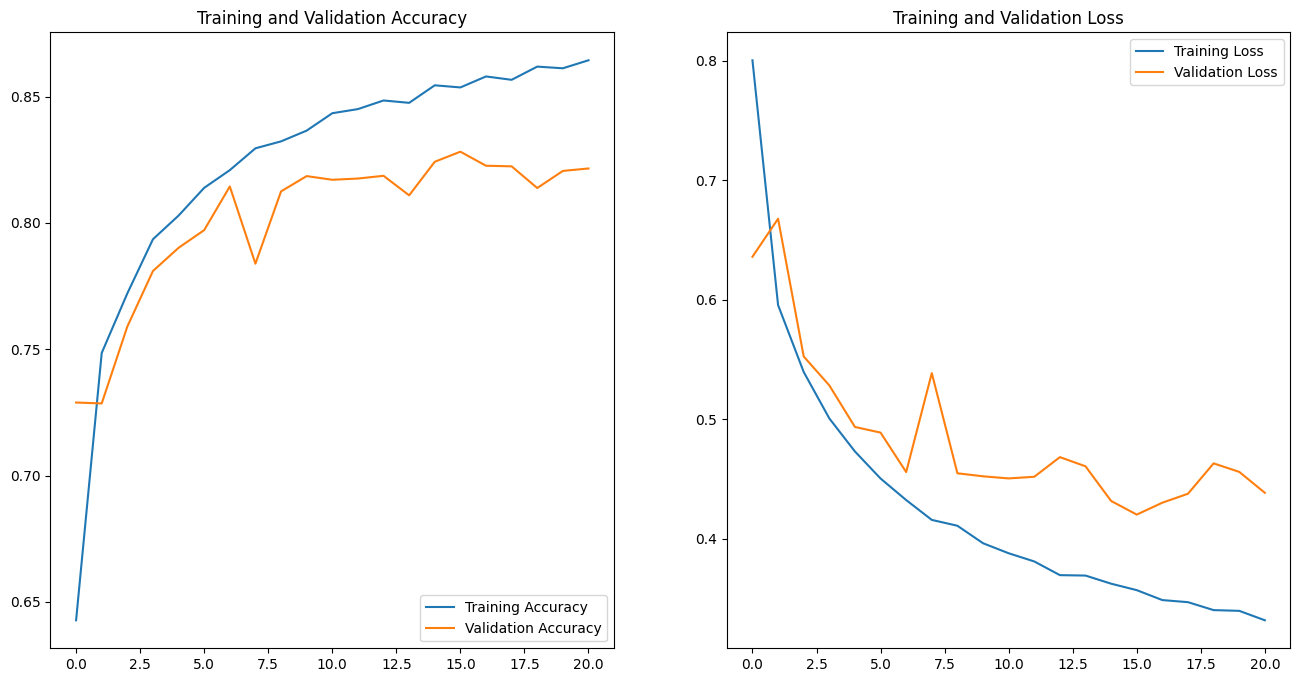

In [24]:
history = model_multiclasse.fit(
  train_multiclasse,
  validation_data=validation_multiclasse,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_multiclasse_dataaug.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

#### CNN 4 couches avec dropout

In [8]:
model_binaire = Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES_BINAIRE)
])

model_multiclasse = Sequential([
    layers.experimental.preprocessing.Rescaling(scale = 1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES_MULTICLASSE)
])

In [9]:
model_binaire.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_binaire.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_binaire.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 40, 40, 1)           0         
                                                                 
 conv2d (Conv2D)             (32, 40, 40, 16)          160       
                                                                 
 max_pooling2d (MaxPooling2  (32, 20, 20, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 20, 20, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 10, 10, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 10, 10, 64)          1

In [10]:
model_multiclasse.compile(optimizer = "adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_multiclasse.build((BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
model_multiclasse.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (32, 40, 40, 1)           0         
                                                                 
 conv2d_4 (Conv2D)           (32, 40, 40, 16)          160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 20, 20, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 20, 20, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 10, 10, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 10, 10, 64)         

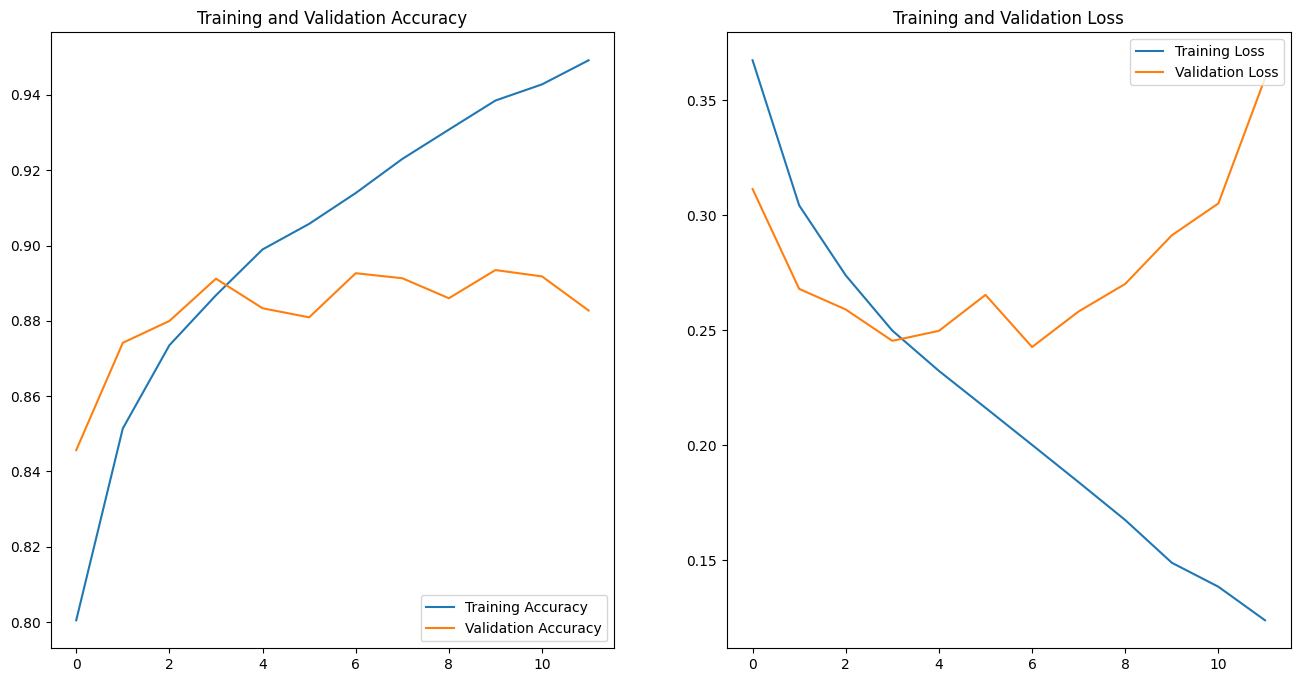

In [15]:
history = model_binaire.fit(
  train_binaire,
  validation_data=validation_binaire,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_binaire_dropout_4couches.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)

Epoch 1/50
1036/1036 [==============================] - ETA: 0s - loss: 0.8100 - accuracy: 0.6286

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 93s 85ms/step - loss: 0.8100 - accuracy: 0.6286 - val_loss: 0.6463 - val_accuracy: 0.6921
Epoch 2/50
1032/1036 [============================>.] - ETA: 0s - loss: 0.5942 - accuracy: 0.7396

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 84ms/step - loss: 0.5942 - accuracy: 0.7396 - val_loss: 0.5031 - val_accuracy: 0.7669
Epoch 3/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.7824

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.5145 - accuracy: 0.7825 - val_loss: 0.4427 - val_accuracy: 0.8186
Epoch 4/50
1036/1036 [==============================] - ETA: 0s - loss: 0.4760 - accuracy: 0.8014

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.4760 - accuracy: 0.8014 - val_loss: 0.4334 - val_accuracy: 0.8253
Epoch 5/50
1036/1036 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8182

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 86s 83ms/step - loss: 0.4436 - accuracy: 0.8182 - val_loss: 0.4276 - val_accuracy: 0.8256
Epoch 6/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8292

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 89s 86ms/step - loss: 0.4172 - accuracy: 0.8293 - val_loss: 0.3983 - val_accuracy: 0.8370
Epoch 7/50
1032/1036 [============================>.] - ETA: 0s - loss: 0.3864 - accuracy: 0.8443

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 85ms/step - loss: 0.3862 - accuracy: 0.8443 - val_loss: 0.4162 - val_accuracy: 0.8305
Epoch 8/50
1032/1036 [============================>.] - ETA: 0s - loss: 0.3708 - accuracy: 0.8493

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 83ms/step - loss: 0.3709 - accuracy: 0.8492 - val_loss: 0.3834 - val_accuracy: 0.8445
Epoch 9/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3480 - accuracy: 0.8612

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 83ms/step - loss: 0.3481 - accuracy: 0.8611 - val_loss: 0.3893 - val_accuracy: 0.8393
Epoch 10/50
1035/1036 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8701

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 120s 115ms/step - loss: 0.3260 - accuracy: 0.8701 - val_loss: 0.3764 - val_accuracy: 0.8503
Epoch 11/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8750

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 90ms/step - loss: 0.3169 - accuracy: 0.8750 - val_loss: 0.3862 - val_accuracy: 0.8469
Epoch 12/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.2949 - accuracy: 0.8838

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 87s 83ms/step - loss: 0.2948 - accuracy: 0.8839 - val_loss: 0.3644 - val_accuracy: 0.8534
Epoch 13/50
1036/1036 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.8917

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 92s 88ms/step - loss: 0.2761 - accuracy: 0.8917 - val_loss: 0.3996 - val_accuracy: 0.8458
Epoch 14/50
1034/1036 [============================>.] - ETA: 0s - loss: 0.2611 - accuracy: 0.8985

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 94s 90ms/step - loss: 0.2611 - accuracy: 0.8985 - val_loss: 0.3824 - val_accuracy: 0.8536
Epoch 15/50
1036/1036 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9044

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 85s 81ms/step - loss: 0.2470 - accuracy: 0.9044 - val_loss: 0.4115 - val_accuracy: 0.8529
Epoch 16/50
1033/1036 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.9104

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 88s 84ms/step - loss: 0.2327 - accuracy: 0.9104 - val_loss: 0.4029 - val_accuracy: 0.8506
Epoch 17/50
1036/1036 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9153

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


1036/1036 [==============================] - 90s 87ms/step - loss: 0.2182 - accuracy: 0.9153 - val_loss: 0.4437 - val_accuracy: 0.8416


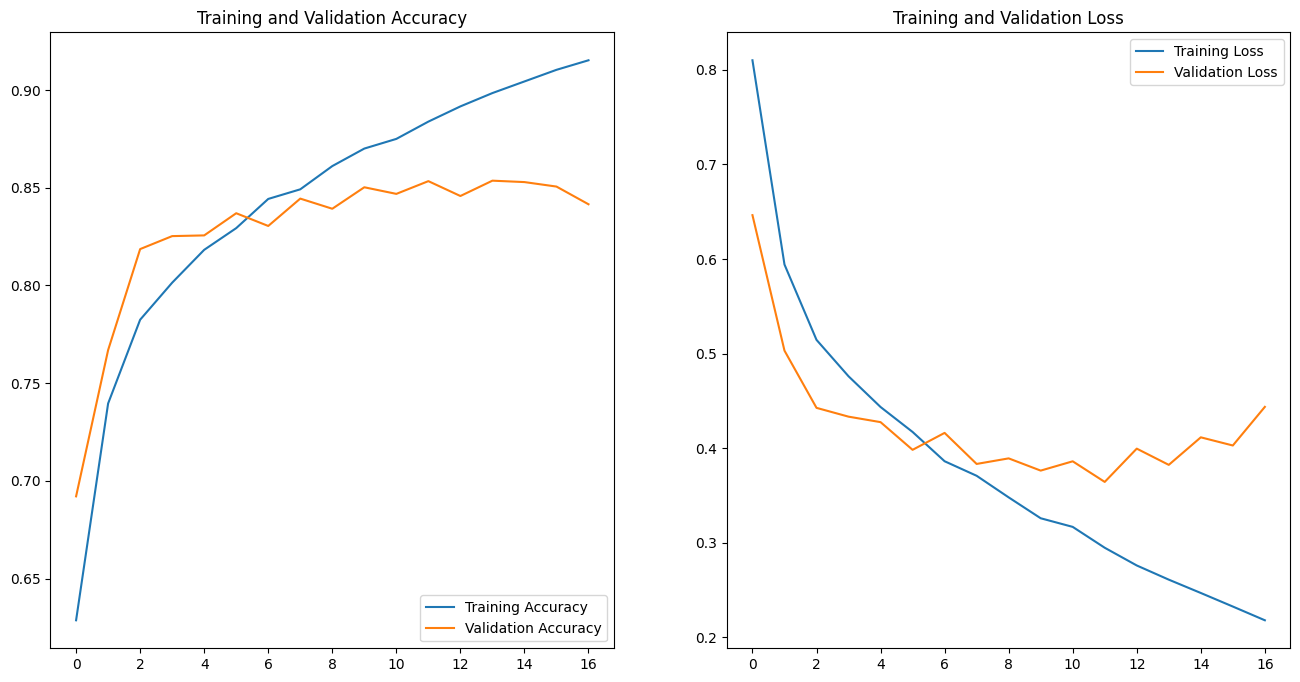

In [16]:
history = model_multiclasse.fit(
  train_multiclasse,
  validation_data=validation_multiclasse,
  epochs=EPOCHS,
  callbacks=[
    callback_earlystopping,
    tf.keras.callbacks.ModelCheckpoint(filepath='best_multiclasse_dropout_4couches.h5', monitor='val_loss', save_best_only=True)
  ]
)

show_metrics(history)